In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
fontsize=14

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import sys
sys.path.append('..')
# sys.path.append('../adaprobe/')
import adaprobe
from adaprobe.psc_denoiser import NeuralDenoiser, DenoisingNetwork
fontsize=14

In [4]:
denoiser = NeuralDenoiser(path='denoisers/nl3_ch8_4_1_ks599_pad299_epochs_7k/nl3_ch8_4_1_ks599_pad299_chkpt_7000.pt') # pretty good, some over-estimation
# denoiser = NeuralDenoiser(path='denoisers/nl3_ch16_8_1_ks399_pad199/_chkpt_2950.pt') # some weird multi-modal shapes
# denoiser = NeuralDenoiser(path='denoisers/nl3_ch8_4_1_ks399_pad199/_chkpt_2950.pt') # similar weird multi-modality
# denoiser = NeuralDenoiser(path='denoisers/nl4_ch16_8_4_1_ks399_pad199/_chkpt_2950.pt')
# denoiser = NeuralDenoiser(path='denoisers/waveform_isolator/nl3_ch16_8_1_ks399_pd199_chkpt_950_chkpt_150_chkpt_1000.pt')
# denoiser = NeuralDenoiser(kernel_size=399, padding=199)

In [9]:
denoiser.generate_training_data(trial_dur=900, size=500, gp_scale=0.03, min_delta=160, 
                                delta_upper=240, next_min_delta=400, next_delta_upper=500,
                               tau_diff_lower=1, tau_diff_upper=150, tau_r_lower=1, tau_r_upper=80)

../adaprobe/psc_denoiser.py:170: RuntimeWarning: overflow encountered in exp
  return lambda x: (np.exp(-(x - delta)/tau_d) - np.exp(-(x - delta)/tau_r)) * (x >= delta)
../adaprobe/psc_denoiser.py:170: RuntimeWarning: invalid value encountered in multiply
  return lambda x: (np.exp(-(x - delta)/tau_d) - np.exp(-(x - delta)/tau_r)) * (x >= delta)


In [6]:
inputs, targets = denoiser.training_data
test_inputs, test_targets = denoiser.test_data

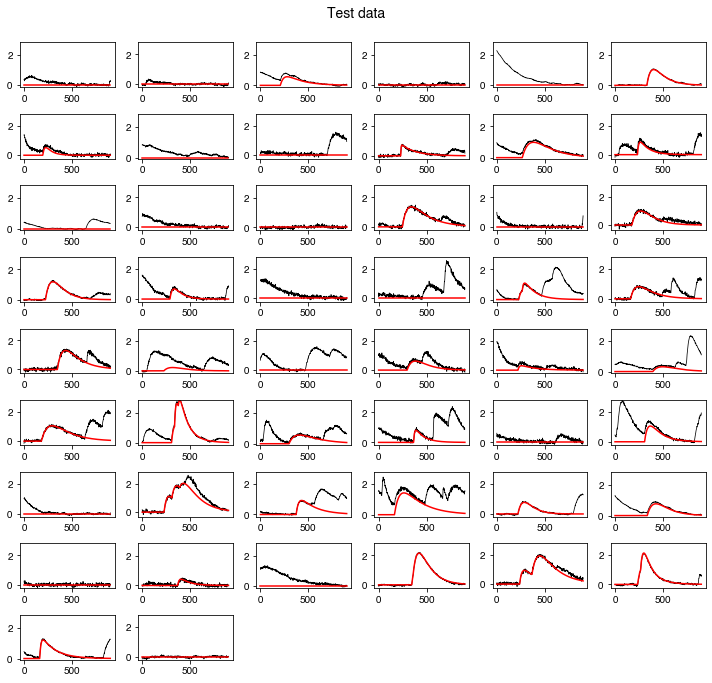

In [7]:
nplots = 50
plt.figure(figsize=(10, nplots * 1))
plot_cntr = 1
for n in range(nplots):
    plt.subplot(nplots, 6, plot_cntr)
    plt.plot(test_inputs[n], color='k', linewidth=0.75)
    plt.plot(test_targets[n], color='r')
    plot_cntr += 1
    plt.ylim(top=np.max(test_targets))
plt.suptitle('Test data', fontsize=fontsize, y=1)
plt.tight_layout()
# plt.savefig('waveform_denoising_example_test_data.png', format='png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [10]:
from adaprobe.psc_denoiser import _sample_psc_kernel

In [16]:
n_samples = 1000
_samps = _sample_psc_kernel(n_samples=n_samples, trial_dur=900, tau_diff_lower=1, tau_diff_upper=150, tau_r_lower=1, tau_r_upper=80)

In [ ]:
_max = np.max(_samps, 1)[:, None]
amps = np.random.uniform(0.1, 1.5, n_samples)[:, None]

In [ ]:
%time scaled_samps = _samps/_max * amps

In [ ]:
trange = np.arange(-5, 41, 5)

In [ ]:
trange

In [ ]:
np.arange(0, 901, 100)

In [ ]:
plt.plot(scaled_samps.T)
plt.xticks(np.arange(0, 901, 100))
plt.gca().set_xticklabels(trange)
plt.show()

In [ ]:
scaled_samps.shape

In [ ]:
len(trange)

In [ ]:
len(np.arange(0, 901, 100))

In [ ]:
45 * 20

In [ ]:
# torch.save(denoiser.denoiser, 'denoisers/waveform_isolator/nl3_ch16_8_1_ks399_pd199_chkpt_950_chkpt_150_chkpt_1000.pt')

In [ ]:
pred_test = denoiser(test_targets)

In [ ]:
nplots = 50
plt.figure(figsize=(15, nplots * 2))
plot_cntr = 1
for n in range(nplots):
    plt.subplot(nplots, 6, plot_cntr)
    plt.plot(test_inputs[n], color='k', linewidth=0.75)
    plt.plot(test_targets[n], color='r')
    plt.plot(pred_test[n], color='b')
    plot_cntr += 1
#     plt.ylim(top=np.max(test_targets))
plt.suptitle('Test data', fontsize=fontsize, y=1)
plt.tight_layout()
# plt.savefig('waveform_denoising_example_test_data.png', format='png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
weights2 = denoiser.denoiser.layers[2].weight.detach().numpy().squeeze()

for i in range(weights2.shape[0]):
    plt.figure(figsize=(10, 3))
    plt.imshow(weights2[i], aspect='auto')#, interpolation='nearest')
    plt.show()

In [ ]:
fname = 'SST_210608_cell1_map_A_45ms_trial'
data = np.load('data/%s.npz'%fname)

psc, L, I, sigma = 20 * data['psc'], data['L'], data['I'], data['sigma']
K = psc.shape[0]

denoised_psc = denoiser(psc)

In [ ]:
nplots = 100
plot_start = 500
plt.figure(figsize=(18, nplots * 1.5))
plot_cntr = 1
for n in range(plot_start, plot_start + nplots):
    plt.subplot(nplots, 8, plot_cntr)
    plt.plot(psc[n], color='k', linewidth=0.75)
    plt.plot(denoised_psc[n], color='b')
    plot_cntr += 1
#     plt.ylim(top=1.05 * np.max(psc[plot_start:plot_start + nplots]))
plt.tight_layout()
plt.show()

In [ ]:
def _build_stimulus_matrix(L, I):
    targets = np.unique(L, axis=0)
    N, K = targets.shape[0], L.shape[0]
    stimulus_matrix = np.zeros((N, K))
    for n in range(N):
        locs = np.where((L == targets[n]).all(axis=1))[0]
        stimulus_matrix[n, locs] = I[locs]
    return stimulus_matrix

stimulus_matrix = _build_stimulus_matrix(L, I)

In [ ]:
trial_dur = 900
n_repeats = 30
N = stimulus_matrix.shape[0]

In [ ]:
trial_breaks = np.arange(0, trial_dur * n_repeats + 1, trial_dur)
n_plots = N
row_height = 0.5
col_width = 7.5
ncols = 3

print(fname)
plt.figure(figsize=(col_width * ncols, row_height * n_plots))

pmax = np.max(np.abs(denoised_psc))

for n in range(N):
    # Spike predictions
    plt.subplot(n_plots, ncols, n+1)
    stim_locs = np.where(stimulus_matrix[n] > 0)[0]
    this_y_psc = psc[stim_locs].flatten()/pmax
    this_denoised_psc = denoised_psc[stim_locs].flatten()/pmax

    plt.xlim([0, trial_dur*n_repeats])
    for tb in range(len(trial_breaks) - 1):
        plt.plot([trial_breaks[tb], trial_breaks[tb]], [-0.05, 1.05], '--', color='k')
    plt.plot(this_y_psc, color='k', linewidth=0.8)
    plt.plot(this_denoised_psc, color='b', linewidth=0.5)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(n+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')
#     plt.ylim([-0.03, 0.4])
    
plt.suptitle('Waveform denoising ' + fname, y=0.885, fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)
# plt.savefig('figs/waveform_denoising/%s_denoised.png'%fname, format='png', bbox_inches='tight', dpi=600, facecolor='white')
plt.show()

In [ ]:
5 * 20

In [ ]:
nplots = 12
plt.figure(figsize=(12, nplots * 1.75))
plot_cntr = 1
leg_nrn = 4

for n in range(nplots):
    plt.subplot(nplots, 4, plot_cntr)
    locs = np.where(stimulus_matrix[n] > 0)[0]
    for indx, loc in enumerate(locs):
        if indx == 0 and n == leg_nrn:
            label_raw = 'Raw'
            label_den = 'Demixed'
        else:
            label_raw = None
            label_den = None
        plt.plot(psc[loc], color='gray', linewidth=0.75, label=label_raw)
        plt.plot(denoised_psc[loc], color='b', alpha=0.85, label=label_den)

    if n == leg_nrn:
        plt.legend(fontsize=fontsize, frameon=True)
    
    plt.xticks(np.arange(0, trial_dur + 1, 5*20), fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    if n >= nplots - 4:
        plt.gca().set_xticklabels(np.arange(-5, 41, 5))
        plt.xlabel('Time (ms)', fontsize=fontsize-2)
    else:
        plt.gca().set_xticklabels([])
    if n % 4 == 0:
        plt.ylabel('Current (pA)', fontsize=fontsize-2)
    plot_cntr += 1
# plt.suptitle('Neural network-based overlapping PSC demixing', fontsize=fontsize, y=0.9)
# plt.savefig('figs/waveform_denoising/waveform_denoising_overlay_example_%s.pdf'%fname, format='pdf', bbox_inches='tight', backend='pgf')
plt.show()

In [ ]:
noise_stds = [1e-2, 1e-1, 1e0]
noise_samples = np.array([np.random.normal(0, std, trial_dur) for std in noise_stds])
n_samples = len(noise_stds)
den_noise = denoiser(noise_samples)

D = np.array([[i - j for i in range(trial_dur)] for j in range(trial_dur)])
lengthscale = 25
K = np.exp(-D**2/(2 * lengthscale**2))

gp_scales = np.array([1e-2, 1e-1, 1e0])

gp_samples = np.random.multivariate_normal(np.zeros(trial_dur), K, n_samples) * gp_scales[:, None]
den_gp = denoiser(gp_samples)

ylim = [-1, 1]
ncols = 8

In [ ]:
plt.figure(figsize=(21, 6))
plot_cntr = 1
for i in range(n_samples):
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(noise_samples[i], color='k')
    plt.title('IID noise ($\sigma$ = %.2f)'%noise_stds[i])
    plt.ylim(ylim)
#     plt.legend(fontsize=fontsize, frameon=False)
    plot_cntr += 1
    
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(den_noise[i], color='b')
    plt.title('Denoised')
    plt.ylim(ylim)
    plot_cntr += 1
    
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(gp_samples[i], color='k')
    plt.title('Correlated noise (scale = %.2f)'%gp_scales[i])
    plt.ylim(ylim)
    plot_cntr += 1
    
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(den_gp[i], color='b')
    plt.ylim(ylim)
    plot_cntr += 1
    
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(test_inputs[i], color='k')
    plt.title('Test input (simulated)')
    plt.ylim(ylim)
    plot_cntr += 1
    
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(test_targets[i], color='r')
    plt.plot(pred_test[i], color='b')
    plt.title('Denoised')
    plt.ylim(ylim)
    plt.legend(['Target', 'Prediction'], frameon=False)
    plot_cntr += 1
    
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(psc[i], color='k')
    plt.ylim(ylim)
    plt.title('Expt data')
    plot_cntr += 1
        
    plt.subplot(n_samples, ncols, plot_cntr)
    plt.plot(denoised_psc[i], color='b')
    plt.title('Denoised')
    plt.ylim(ylim)
    plot_cntr += 1
    
plt.tight_layout()
# plt.savefig('figs/waveform_denoising/denoiser_vs_various_noise_types.pdf', format='pdf', bbox_inches='tight')


plt.show()

In [ ]:
col_reset = 8

In [ ]:
ncols = 8
cells_per_row = int((ncols-2)/2)
xticks = np.arange(0, 801, 400)
xticklabels = np.arange(0, 41, 20)

In [ ]:
example_nrn = 28
locs = np.where(stimulus_matrix[example_nrn] > 0)[0]

plt.figure(figsize=(2, 2))
plt.plot(psc[locs].T, color='k')
# plt.axis('off')
# plt.savefig('figs/diagrams/psc_example_raw_%s_%i.pdf'%(fname, example_nrn), format='pdf', bbox_inches='tight')
ylim = plt.gca().get_ylim()
plt.show()

plt.figure(figsize=(2, 2))
plt.plot(denoised_psc[locs].T, color='b', alpha=1)
plt.axis('off')
plt.ylim(ylim)
# plt.savefig('figs/diagrams/psc_example_denoised_%s_%i.pdf'%(fname, example_nrn), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib
import colorcet
# cmap = matplotlib.cm.get_cmap('tab20')

In [ ]:
fontsize = 14

In [ ]:
cmap = colorcet.cm.glasbey

In [ ]:
fnames = [f for f in os.listdir('data') if 'SST' in f and '45ms' in f]

In [ ]:
fnames

In [ ]:
trial_dur = 900
n_repeats = 30
widths = [1.5, 1.5, 0.25, 1.5, 1.5, 0.25, 1.5, 1.5]
ms = 20
nplots = 12
nrows = int(np.ceil(nplots/cells_per_row))

for i in range(len(fnames)):
    # Load data
    fname = fnames[i][:-4]
    data = np.load('data/%s.npz'%fname)

    psc, L, I, sigma = 20 * data['psc'], data['L'], data['I'], data['sigma']
    K = psc.shape[0]
    stimulus_matrix = _build_stimulus_matrix(L, I)
    
    # Denoise
    %time denoised_psc = denoiser(psc)

    # Plot fig
    fig = plt.figure(figsize=(10.5, 1.2 * nrows))
    g = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths)
    row_counter = 0
    col_counter = 0
    for n in range(nplots):
        locs = np.where(stimulus_matrix[n] > 0)[0]
        ymin = np.min([np.min(psc[locs]), np.min(denoised_psc[locs])])
        ymax = 1.05 * np.max([np.max(psc[locs]), np.max(denoised_psc[locs])])
        norm = matplotlib.colors.Normalize(vmin=0, vmax=len(locs))
        rord = np.random.choice(len(locs), len(locs), replace=False)

        fig.add_subplot(g[row_counter, col_counter])
        for indx, loc in enumerate(locs):
            plt.plot(np.arange(-5*ms, 40*ms), psc[loc], color=cmap(norm(rord[indx])))
        plt.ylim([ymin, ymax])
        plt.xticks(xticks)
        plt.gca().set_xticklabels(xticklabels, fontsize=fontsize)
        if row_counter == 0:
            plt.title('Raw', fontsize=fontsize)
        col_counter +=1

        if row_counter == nrows - 1:
            for l in ['top', 'right', 'left']:
                plt.gca().spines[l].set_visible(False)
                plt.xticks(np.arange(-5*ms, 41*ms, 5*ms))
                plt.xlabel('Time (ms)', fontsize=fontsize)
        else:
            for l in ['top', 'right', 'bottom', 'left']:
                plt.gca().spines[l].set_visible(False)
                plt.xticks([])
        plt.yticks([])
        plt.xlim([-5*ms, 40*ms])

        fig.add_subplot(g[row_counter, col_counter])
        for indx, loc in enumerate(locs):
            plt.plot(np.arange(-5*ms, 40*ms), denoised_psc[loc], color=cmap(norm(rord[indx])))
        plt.ylim([ymin, ymax])
        plt.gca().set_yticklabels([])
        plt.xticks(xticks)
        plt.gca().set_xticklabels(xticklabels)

        if row_counter == 0:
            plt.title('Denoised', fontsize=fontsize)
        col_counter += 1

        if row_counter == nrows - 1:
            for l in ['top', 'right', 'left']:
                plt.gca().spines[l].set_visible(False)
                plt.xticks(np.arange(-5*ms, 41*ms, 5*ms), fontsize=fontsize)
                plt.xlabel('Time (ms)', fontsize=fontsize)
        else:
            for l in ['top', 'right', 'bottom', 'left']:
                plt.gca().spines[l].set_visible(False)
                plt.xticks([])
        plt.yticks([])
        plt.xlim([-5*ms, 40*ms])

        if col_counter == col_reset:
            row_counter += 1
            col_counter = 0
        else:
            fig.add_subplot(g[row_counter, col_counter])
            plt.axis('off')
            col_counter += 1


#     plt.savefig('figs/waveform_denoising/multicolour_examples/waveform_denoised_PSCs_sample_%s_multicolour.pdf'%fname, format='pdf', bbox_inches='tight', backend='pgf')
#     plt.savefig('figs/waveform_denoising/multicolour_examples/waveform_denoised_PSCs_sample_%s_multicolour_tab20.png'%fname, 
#                 format='png', facecolor='white', bbox_inches='tight')
    plt.show()

# Example input + target

In [ ]:
trial_dur = 800
xrange = np.arange(trial_dur)

tau_r = 80
tau_d = 100
delta = 150

sigma = 0.01

In [ ]:
def kernel_func(tau_r, tau_d, delta):
    return lambda x: (np.exp(-(x - delta)/tau_d) - np.exp(-(x - delta)/tau_r)) * (x >= delta)

In [ ]:
psc = kernel_func(tau_r, tau_d, delta)(xrange)

noise_psc = kernel_func(tau_r, tau_d, -200)(xrange) + np.random.normal(0, sigma, len(xrange))

lp_cutoff = 500
srate = 2000
b_lp, a_lp = sg.butter(4, lp_cutoff, btype='low', fs=srate)

psc, noise_psc = [sg.filtfilt(b_lp, a_lp, trace, axis=-1) for trace in [psc, noise_psc]]

In [ ]:
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title('Input')
plt.plot(psc + noise_psc)
plt.ylim(top=0.125)
plt.subplot(1, 2, 2)
plt.title('Target')
plt.plot(psc)
plt.ylim(top=0.125)
plt.show()

# Sample training data

In [ ]:
D = np.array([[i - j for i in range(trial_dur)] for j in range(trial_dur)])

def sample_gp(lengthscale=25, scale=0.01, trial_dur=800, n_samples=1):
    K = np.exp(-D**2/(2*lengthscale**2))
    mean = np.zeros(trial_dur)
    return scale * np.random.multivariate_normal(mean, K, size=n_samples)

In [ ]:
def sample_kern(tau_r_lower=10, tau_r_upper=80, tau_diff_lower=50, tau_diff_upper=150, min_delta=100, delta_lower=0, 
                delta_upper=200, trial_dur=800, n_samples=1):
    tau_r_samples = np.random.uniform(tau_r_lower, tau_r_upper, n_samples)
    tau_diff_samples = np.random.uniform(tau_diff_lower, tau_diff_upper, n_samples)
    tau_d_samples = tau_r_samples + tau_diff_samples
    delta_samples = min_delta + np.random.uniform(delta_lower, delta_upper, n_samples)
    xrange = np.arange(trial_dur)
    return np.array([kernel_func(tau_r_samples[i], tau_d_samples[i], delta_samples[i])(xrange) for i in range(n_samples)])

In [ ]:
plt.plot(sample_kern(n_samples=30).T)
plt.show()

In [ ]:
plt.plot(sample_kern(n_samples=30).T + sample_gp(n_samples=30, scale=0.02).T)
plt.show()

In [ ]:
plt.plot(sample_gp(n_samples=30, scale=0.02).T)
plt.show()

In [ ]:
plt.plot(np.sum(sample_kern(n_samples=3), 0))

In [ ]:
np.random.choice(4, 5, p=[0.25, 0.25, 0.25, 0.25])

In [ ]:
mode_probs = [0.3, 0.5, 0.1, 0.1]
n_samples = 1000

n_modes = np.random.choice(range(4), n_samples, p=mode_probs)
n_modes_prev = np.random.choice(range(4), n_samples, p=mode_probs)
targets = np.zeros((n_samples, trial_dur))
prev_pscs = np.zeros((n_samples, trial_dur))
noise_stds = np.random.uniform(0.01, 0.1, n_samples)
noise = np.zeros((n_samples, trial_dur))
gp_noise = sample_gp(n_samples=n_samples, scale=0.03)
for n in range(n_samples):
    targets[n] = np.sum(sample_kern(n_samples=n_modes[n], delta_upper=400), 0)
    prev_pscs[n] = np.sum(sample_kern(n_samples=n_modes_prev[n], min_delta=0, 
                          delta_lower=-400, delta_upper=-100), 0)
    noise[n] = np.random.normal(0, noise_stds[n], trial_dur)
    
inputs = sg.filtfilt(b_lp, a_lp, prev_pscs + targets + gp_noise + noise, axis=-1)

In [ ]:
plt.figure()
plt.plot(targets[:30].T)
plt.show()

In [ ]:
plt.figure()
plt.plot(prev_pscs[:30].T)
plt.show()

In [ ]:
nplots = 60
plt.figure(figsize=(20, nplots * 2))
for n in range(nplots):
    plt.subplot(nplots, 6, n+1)
    plt.plot(inputs[n], color='k')
    plt.plot(targets[n], color='r')
    plt.ylim(top=np.max(targets))
# plt.savefig('sample_psc_training_data.png', format='png', dpi=200, facecolor='white', bbox_inches='tight')
plt.show()

# Neural network training


    o = output
    p = padding
    k = kernel_size
    s = stride
    d = dilation

 o = floor([i + 2*p - d * (k-1) - 1]/s + 1)
     floor([800 + 2p - k + 1 - 1]/s + 1)
     floor([800 + 2p - k]/s + 1)
800 = floor([800 + 2p - k]/s + 1)

if k = 99, s = 1
800 = floor(800 + 2p - 98)

<!-- (800 + 2p - 100)/2 -->

In [ ]:
def choose_padding(trial_dur, kernel_size, stride):
    return ((trial_dur - 1) * stride + kernel_size - 1 - trial_dur)/2

In [ ]:
choose_padding(800, 100, 1)

In [ ]:
# padding = 49
# kernel_size = 99
# stride = 2

# class PSCDenoiser(torch.nn.Module):
#     def __init__(self):
#         super(PSCDenoiser, self).__init__()
#         self.layer1 = torch.nn.Conv1d(in_channels=1, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1)
#         self.layer2 = torch.nn.Conv1d(in_channels=32, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1)
#         self.layer3 = torch.nn.Conv1d(in_channels=16, out_channels=1, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1)
# #         self.layer4 = torch.nn.Conv1d(in_channels=5, out_channels=1, kernel_size=9, stride=1, padding=4, dilation=1)
#         self.relu = torch.nn.ReLU()
#     def forward(self, x):
#         x = self.relu(self.layer1(x))
#         x = self.relu(self.layer2(x))
#         x = self.relu(self.layer3(x))
# #         x = self.relu(self.layer4(x))
#         return x

In [ ]:
padding = 49
kernel_size = 99
stride = 2

class PSCDenoiser_autoenc(torch.nn.Module):
    def __init__(self):
        
        super(PSCDenoiser_autoenc, self).__init__()
        self.maxpool = nn.MaxPool1d(3, stride=2, return_indices=True)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=16, stride=2, padding=0, dilation=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=2, padding=0, dilation=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=16, stride=1, padding=0, dilation=1)
        
        self.maxunpool = nn.MaxUnpool1d(3, stride=2, padding=0)
        self.deconv3 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=16, stride=1, padding=0, output_padding=0)
        self.deconv2 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=16, stride=2, padding=0, output_padding=1)
        self.deconv1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=16, stride=2, padding=0, output_padding=0)

        self.relu = nn.ReLU()
        self.layers = [self.conv1, self.conv2, self.conv3, self.deconv3, self.deconv2, self.deconv1]
#         self.layers = [self.conv1, self.conv2, self.deconv2, self.deconv3]
        
    def forward(self, x, debug=False):
        # Encoding
        x = self.relu(self.conv1(x))
        x, inds1 = self.maxpool(x)
        if debug: print('maxpool', x.shape)
        x = self.relu(self.conv2(x))
        if debug: print('conv', x.shape)
#         x, inds2 = self.maxpool(x)
#         if debug: print('maxpool', x.shape)
        x = self.relu(self.conv3(x))
        if debug: print('conv', x.shape)
        
        if debug: print('')
        # Decoding
        x = self.relu(self.deconv3(x))
        if debug: print('deconv', x.shape)
#         x = self.maxunpool(x, inds2)
#         if debug: print('unpool', x.shape)
        x = self.relu(self.deconv2(x))
        if debug: print('deconv', x.shape)
        x = self.maxunpool(x, inds1)
        if debug: print('unpool', x.shape)
        x = self.relu(self.deconv1(x))
        
#         for layer in self.layers:
#             x = self.relu(layer(x))        
        return x

In [ ]:
_test_inputs = torch.tensor(np.expand_dims(test_inputs, 1).copy()).float()

In [ ]:
model = PSCDenoiser_autoenc().float()

In [ ]:
model(_test_inputs).detach().numpy().squeeze()[0].shape

In [ ]:
plt.plot(model(_test_inputs).detach().numpy().squeeze()[0])

In [ ]:
# maxpool = nn.MaxPool1d(3, stride=2, return_indices=True)
# conv1 = torch.nn.Conv1d(in_channels=1, out_channels=8, kernel_size=16, stride=2, padding=0, dilation=1)
# conv2 = torch.nn.Conv1d(in_channels=8, out_channels=16, kernel_size=16, stride=2, padding=0, dilation=1)
# conv3 = torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=16, stride=1, padding=1, dilation=1)
# # conv4 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1, dilation=1)

# maxunpool = nn.MaxUnpool1d(3, stride=2, padding=1)
# # deconv0 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=0, output_padding=0)
# deconv1 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=32, stride=2, padding=1, output_padding=0)
# deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=32, stride=1, padding=1, output_padding=0)
# deconv3 = nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=32, stride=1, padding=1, output_padding=1)

In [ ]:
# # Encoding

# x = _test_inputs.clone()

# x = conv1(x)
# print(x.shape)
# x, inds = maxpool(x)
# print(x.shape)

# x = conv2(x)
# print(x.shape)
# x, inds = maxpool(x)
# print(x.shape)

# x = conv3(x)
# print(x.shape)
# x, inds = maxpool(x)
# print(x.shape)



# # x = conv4(x)
# # print(x.shape)

# # Decoding

# x = deconv0(x)
# print(x.shape)
# x = deconv1(x)
# print(x.shape)
# # x = maxunpool(x, inds)
# # print(x.shape)
# x = deconv2(x)
# print(x.shape)
# x = deconv3(x)
# print(x.shape)

In [ ]:
plt.plot(inputs[0])
plt.plot(targets[0])

In [ ]:
# model = PSCDenoiser().double()

In [ ]:
# _inputs = torch.tensor(inputs.reshape([n_samples, 1, trial_dur]).copy())

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PSCData(Dataset):
    """The training table dataset.
    """
    def __init__(self, inputs, targets):
        n_samples, trial_len = inputs.shape
        inputs = inputs.copy().reshape([n_samples, 1, trial_len])
        targets = targets.copy().reshape([n_samples, 1, trial_len])
        self.x_data = [torch.from_numpy(row) for row in inputs]
        self.y_data = [torch.from_numpy(row) for row in targets]
        self.len = inputs.shape[0]
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len

In [ ]:
n_samples = inputs.shape[0]

In [ ]:
n_train = int(0.9 * inputs.shape[0])
test_frac = n_samples - n_train

# Denoising
training_data = PSCData(inputs[:n_train], targets[:n_train])
test_data = PSCData(inputs[n_train:], targets[n_train:])

# AUTOENCODING
# training_data = PSCData(inputs[:n_train], inputs[:n_train])
# test_data = PSCData(inputs[n_train:], inputs[n_train:])

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [ ]:
# model = PSCDenoiser().double()

In [ ]:
model = PSCDenoiser_autoenc().double()

In [ ]:
plt.plot(model(torch.tensor(np.expand_dims(inputs.copy(), 1))).detach().numpy().squeeze()[0])
plt.plot(targets[0])

In [ ]:
learning_rate = 1e-2
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
test_loop(test_dataloader, denoiser.denoiser.double(), loss_fn)

In [ ]:
epochs = 10000
loss_ls = np.zeros(epochs)
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    loss_ls[t] = test_loop(test_dataloader, model, loss_fn)
    print('Epoch %i/%i Loss: %.10f (delta %.10f)'%(t+1, epochs, loss_ls[t], loss_ls[t] - loss_ls[t-1]), end='\r')
print("Done!")

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(loss_ls[:t])
plt.yscale('log')
plt.show()

In [ ]:
pred = denoiser.denoiser(torch.tensor(np.expand_dims(inputs.copy(), 1))).detach().numpy().squeeze()

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.plot(inputs[i], color='k')
    plt.plot(targets[i], color='r')
    plt.plot(pred[i], 'b-')
    plt.ylim([0, np.max(inputs)])
plt.show()

In [ ]:
# import copy
# model_chkpt = copy.deepcopy(model)

In [ ]:
pred = model(_inputs).squeeze().detach().numpy()

In [ ]:
nplots = 100
plt.figure(figsize=(15, nplots * 2))
plot_cntr = 1
for n in range(n_train, n_train + nplots):
    plt.subplot(nplots, 6, plot_cntr)
    plt.plot(inputs[n], color='k', linewidth=0.75)
    plt.plot(targets[n], color='r')
    plt.plot(pred[n], color='b')
    plot_cntr += 1
    plt.ylim(top=np.max(targets))
plt.suptitle('Test data', fontsize=fontsize, y=1)
plt.tight_layout()
# plt.savefig('waveform_denoising_example_test_data.png', format='png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# Test on real data

In [ ]:
data = np.load('data/SST_210609_cell5_map_A.npz')

data.files

psc, L, I, sigma = data['psc'], data['L'], data['I'], data['sigma']
K = psc.shape[0]
raw_data_scale = 10
_psc = torch.tensor(raw_data_scale * psc.reshape([K, 1, trial_dur]))
denoised_psc = model(_psc[:500]).detach().numpy().squeeze()

nplots = 200
plot_start = 0
plt.figure(figsize=(18, nplots * 1.5))
plot_cntr = 1
for n in range(plot_start, plot_start + nplots):
    plt.subplot(nplots, 8, plot_cntr)
    plt.plot(raw_data_scale * psc[n], color='k', linewidth=0.75)
    plt.plot(denoised_psc[n], color='b')
    plot_cntr += 1
    plt.ylim(top=1.05 * np.max(raw_data_scale * psc[plot_start:plot_start + nplots]))
plt.tight_layout()
plt.show()